In [2]:
import scvelo as scv
import scanpy as sc
import numpy as np
import pandas as pd
import random 
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score, mean_squared_error

In [3]:
##### I should do some filtering... Originally: 13960 cells 8009 genes

# Load dataset, with velocity values
    # these values are all normalized by scvelo
vdata = sc.read_h5ad("velocity_adata.h5ad")


In [4]:
# Scale Ms and velocity layer, with mean=0 and unit variance 
    # sc.pp.scale adds mean and std to var, although this relfects only last scaling
    # here we add the velocity scaling to the spliced counts scaling

sc.pp.scale(vdata, layer='Ms')
sc.pp.scale(vdata, layer='velocity')

In [5]:
##### Split data into train and test
    # watch out for time-ordering, randomly choose cells
    # sc.pp.subsample might not work the way I want it to. Have to find another way to create real objects,
    # here only views are created -- not enough i believe, do not have access to the names ??

test, train = train_test_split(vdata, test_size=0.5)

In [6]:
##### Velocity genes

velocity_genes = vdata.var.index[vdata.var['velocity_genes'] == True].tolist()

In [7]:
##### Generate Regression Data

def linear_regression_shuffle(runs:int, genes, tf:str, vdata):
    """ Returns dataframe including p-values, coefficients, and r^2 score of the number of regression runs specified. 
        The number of genes should be less than 5000, else there are no good p-values. In each regression run training and test data is reshuffled"""
    
    
    
    # store data accross all regressions
    frames = []
    r2scores = []
    intercepts = []
    
    
    # Run regressions
    for x in range(runs):
        
        # shuffle data each regression
        test, train = train_test_split(vdata, test_size=0.5)
    
        X_train = train[:, genes].layers['velocity']
        y_train = train[:, tf].layers['Ms']

        X_test = test[:, genes].layers['velocity']
        y_test = test[:, tf].layers['Ms']

        print('starting with ', x)
        #regression
        lin = LinearRegression()
        lin.fit(X_train, y_train)
        params = np.append(lin.intercept_,lin.coef_)
        y_pred = lin.predict(X_test)


        # save values of current regression
        r2scores += [r2_score(y_test, y_pred)]
        intercepts += [lin.intercept_]

        delta_y = y_test - y_pred


        # Here we append, why though? appending (6847, 1) and (6847, 6000) on axis= 1, then we get (6847, 6001). Is this necessary? 
        # We are adding one column of 1 infront of everything? Why?
        # P-values: based on https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
        newX = np.append(np.ones((len(X_test),1)), X_test, axis=1)
        MSE = (sum((delta_y**2)))/(len(newX)-len(newX[0]))

        var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
        sd_b = np.sqrt(var_b)
        ts_b = params/ sd_b

        p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

        sd_b = np.round(sd_b,5)
        ts_b = np.round(ts_b,5)
        p_values = np.round(p_values,5)
        params = np.round(params,6)

        # I am not sure if this is right. Why do we need a column of 1s?
        names = ['1'] + genes
        regression = list(np.ones(len(params),)*x)

        
        df = pd.DataFrame()
        df['Genes'], df["Coefficients"], df["Probabilities"], df["Standard Errors"], df["Regression"]= [names, params, p_values, sd_b, regression]
        frames+=[df]



      
    data = pd.concat(frames)
    
    metadata = pd.DataFrame()
    metadata["r2scores"], metadata["intercepts"] = [r2scores, intercepts]
    
    

    return data, metadata


In [13]:
##### Generate Regression Data WIHTOUT SHUFFLING

def linear_regression_NS(runs:int, genes, tf:str, vdata, filename):
    """ Returns dataframe including p-values, coefficients, and r^2 score of the number of regression runs specified. 
        The number of genes should be less than 5000, else there are no good p-values. In each regression run training and test data is reshuffled"""
    
    # shuffle data each regression
    test, train = train_test_split(vdata, test_size=0.5)
    
    X_train = train[:, genes].layers['velocity']
    y_train = train[:, tf].layers['Ms']

    X_test = test[:, genes].layers['velocity']
    y_test = test[:, tf].layers['Ms']
    
    # store data accross all regressions
    frames = []
    r2scores = []
    intercepts = []
    
    
    # Run regressions
    for x in range(runs):
        
        

        print('starting with ', x)
        #regression
        lin = LinearRegression()
        lin.fit(X_train, y_train)
        params = np.append(lin.intercept_,lin.coef_)
        y_pred = lin.predict(X_test)


        # save values of current regression
        r2scores += [r2_score(y_test, y_pred)]
        intercepts += [lin.intercept_]

        delta_y = y_test - y_pred


        # Here we append, why though? appending (6847, 1) and (6847, 6000) on axis= 1, then we get (6847, 6001). Is this necessary? 
        # We are adding one column of 1 infront of everything? Why?
        # P-values: based on https://stackoverflow.com/questions/27928275/find-p-value-significance-in-scikit-learn-linearregression
        newX = np.append(np.ones((len(X_test),1)), X_test, axis=1)
        MSE = (sum((delta_y**2)))/(len(newX)-len(newX[0]))

        var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
        sd_b = np.sqrt(var_b)
        ts_b = params/ sd_b

        p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-len(newX[0])))) for i in ts_b]

        sd_b = np.round(sd_b,5)
        ts_b = np.round(ts_b,5)
        p_values = np.round(p_values,5)
        params = np.round(params,6)

        # I am not sure if this is right. Why do we need a column of 1s?
        names = ['1'] + genes
        regression = list(np.ones(len(params),)*x)

        
        df = pd.DataFrame()
        df['Genes'], df["Coefficients"], df["Probabilities"], df["Standard Errors"], df["Regression"]= [names, params, p_values, sd_b, regression]
        frames+=[df]



      
    data = pd.concat(frames)
    
    metadata = pd.DataFrame()
    metadata["r2scores"], metadata["intercepts"] = [r2scores, intercepts]
    
    data.to_pickle(filename+'.pkl')
    metadata.to_pickle('meta'+filename+'.pkl')
    
    return data, metadata


In [9]:
data, metadata = linear_regression_shuffle(10, velocity_genes, 'Klf2', vdata)


starting with  0
starting with  1
starting with  2
starting with  3
starting with  4
starting with  5
starting with  6
starting with  7
starting with  8
starting with  9


In [11]:
data.to_pickle('data10.pkl')
metadata.to_pickle('meta10.pkl')

In [14]:
odata, ometadata = linear_regression_NS(10, velocity_genes, 'Klf2', vdata, 'a')


starting with  0
starting with  1
starting with  2
starting with  3
starting with  4
starting with  5
starting with  6
starting with  7
starting with  8
starting with  9


In [12]:
data.to_pickle('odata10.pkl')
metadata.to_pickle('ometa10.pkl')

In [135]:
odata

,Genes,Coefficients,Probabilities,Standard Errors,Regression
0,1,-0.002842,0.47458,0.00397,0.0
1,Mrpl15,0.005508,0.30488,0.00537,0.0
2,Mybl1,0.009586,0.07656,0.00541,0.0
3,Mcm3,0.000215,0.97232,0.00620,0.0
4,Smap1,-0.006092,0.23223,0.00510,0.0
...,...,...,...,...,...
1105,Kif4,0.004945,0.44905,0.00653,9.0
1106,Cenpi,-0.000527,0.93767,0.00674,9.0
1107,Smc1a,-0.005212,0.37399,0.00586,9.0
1108,Gpm6b,-0.004960,0.34289,0.00523,9.0


In [173]:
data

,Genes,Coefficients,Probabilities,Standard Errors,Regression
0,1,-0.001721,0.66779,0.00401,0.0
1,Mrpl15,0.007707,0.16223,0.00551,0.0
2,Mybl1,0.012673,0.02202,0.00553,0.0
3,Mcm3,-0.000716,0.90883,0.00625,0.0
4,Smap1,-0.000235,0.96356,0.00513,0.0
...,...,...,...,...,...
1105,Kif4,0.004511,0.50388,0.00675,9.0
1106,Cenpi,0.002842,0.67042,0.00668,9.0
1107,Smc1a,-0.000963,0.87091,0.00593,9.0
1108,Gpm6b,-0.018201,0.00047,0.00520,9.0


In [46]:
# I dont know why this is happening. why are there nans everywhere??
data[data['Genes']=='Klf4']['Coefficients'].var()

nan

In [202]:
# this does not make sense at all. data should have everything, this does not depend on resampling everything. 
data[data['Genes']=='Klf4']

,Genes,Coefficients,Probabilities,Standard Errors,Regression


In [121]:
##### Mean coefficient values
mean = data.groupby('Genes').Coefficients.mean()
mean
# selecting multiple genes: mean.loc[['Aars', 'Aatf']]

Genes
1                0.000227
1110004E09Rik   -0.000567
1500009L16Rik   -0.002218
1600014C10Rik    0.001487
1700017B05Rik   -0.008178
                   ...   
Zeb2             0.021503
Zfp36l1          0.011045
Zfp831          -0.002442
Zranb3          -0.004436
Zwilch           0.013214
Name: Coefficients, Length: 1110, dtype: float32

In [155]:
filtered.index

Index(['1700017B05Rik', '1810011H11Rik', '2310001H17Rik', '2310015A10Rik',
       '2610318N02Rik', '2700094K13Rik', '2810004N23Rik', '2810417H13Rik',
       '5730508B09Rik', 'AI662270',
       ...
       'Xdh', 'Xpo1', 'Xrn2', 'Yars', 'Ybx1', 'Zbp1', 'Zc3h15', 'Zeb2',
       'Zfp36l1', 'Zwilch'],
      dtype='object', name='Genes', length=635)

In [15]:
##### count for each gene, number of times pvalue is below 0.05

# WHY are there 150 (half, approx.) genes that dont have var or std?? Especially when everything else is okay.
# it is because they where only counted once, they only had one p-value below. 
filtered = data[data['Probabilities']<=0.05].groupby('Genes').Coefficients.agg(['count', 'mean', 'var', 'std'])
filtered[filtered['std'].isnull()]

,count,mean,var,std
Genes,,,,
1500009L16Rik,1,-0.012011,NaN,NaN
2610318N02Rik,1,-0.015250,NaN,NaN
AI662270,1,-0.013330,NaN,NaN
Ankle1,1,-0.011271,NaN,NaN
Anln,1,-0.011372,NaN,NaN
...,...,...,...,...
Wdr75,1,-0.013056,NaN,NaN
Wdr76,1,-0.011706,NaN,NaN
Whsc1,1,0.013373,NaN,NaN


In [18]:
# Note to self: Anything done before groupby is the data that is used in the groupby. 

a = data[data['Probabilities']<=0.05].groupby('Genes').var()
a[filtered['std'].isnull()]

,Coefficients,Probabilities,Standard Errors,Regression
Genes,,,,
1500009L16Rik,NaN,NaN,NaN,NaN
2610318N02Rik,NaN,NaN,NaN,NaN
AI662270,NaN,NaN,NaN,NaN
Ankle1,NaN,NaN,NaN,NaN
Anln,NaN,NaN,NaN,NaN
...,...,...,...,...
Wdr75,NaN,NaN,NaN,NaN
Wdr76,NaN,NaN,NaN,NaN
Whsc1,NaN,NaN,NaN,NaN


In [20]:
dd = data.groupby("Genes").Coefficients.agg(['var', 'std', 'mean'])
dd

,var,std,mean
Genes,,,
1,0.000005,0.002132,-0.000661
1110004E09Rik,0.000021,0.004629,0.000358
1500009L16Rik,0.000011,0.003348,-0.004481
1600014C10Rik,0.000007,0.002648,0.002441
1700017B05Rik,0.000011,0.003296,-0.007415
...,...,...,...
Zeb2,0.000008,0.002884,0.019767
Zfp36l1,0.000010,0.003214,0.009872
Zfp831,0.000019,0.004405,-0.003180


In [26]:
data['coef mean'], data['coef var'], data['coef std'] = data.groupby('Genes').Coefficients.transform('mean'), data.groupby('Genes').Coefficients.transform('var'), data.groupby('Genes').Coefficients.transform('std')

In [27]:
data

,Genes,Coefficients,Probabilities,Standard Errors,Regression,mean coefficient,cpef mean,coef var,coef std,coef mean
0,1,-0.002212,0.57894,0.00399,0.0,-0.000661,-0.000661,0.000005,0.002132,-0.000661
1,Mrpl15,0.007057,0.19490,0.00544,0.0,0.006961,0.006961,0.000003,0.001857,0.006961
2,Mybl1,0.012926,0.01860,0.00549,0.0,0.009108,0.009108,0.000014,0.003763,0.009108
3,Mcm3,-0.001860,0.76255,0.00616,0.0,-0.000076,-0.000076,0.000003,0.001859,-0.000076
4,Smap1,-0.001601,0.75577,0.00515,0.0,-0.002054,-0.002054,0.000013,0.003641,-0.002054
...,...,...,...,...,...,...,...,...,...,...
1105,Kif4,0.002889,0.65839,0.00653,9.0,0.006425,0.006425,0.000021,0.004610,0.006425
1106,Cenpi,-0.006654,0.31434,0.00661,9.0,-0.004422,-0.004422,0.000010,0.003116,-0.004422
1107,Smc1a,-0.001985,0.73434,0.00585,9.0,-0.001929,-0.001929,0.000007,0.002731,-0.001929
1108,Gpm6b,-0.013885,0.00905,0.00532,9.0,-0.011180,-0.011180,0.000010,0.003090,-0.011180


In [30]:
data.groupby(['Genes', 'Probabilities']).sum()

Coefficients  Standard Errors  Regression  \
Genes  Probabilities                                              
1      0.25772           -0.004549          0.00402         5.0   
       0.55349           -0.002413          0.00407         8.0   
       0.57894           -0.002212          0.00399         0.0   
       0.60009            0.002117          0.00404         6.0   
       0.69455            0.001601          0.00408         4.0   
...                            ...              ...         ...   
Zwilch 0.04004            0.011919          0.00580         2.0   
       0.21567            0.007254          0.00586         3.0   
       0.22067            0.007307          0.00597         6.0   
       0.29149            0.006367          0.00603         8.0   
       0.33843            0.005654          0.00591         1.0   

                      mean coefficient  cpef mean  coef var  coef std  \
Genes  Probabilities                                                    
1      0.25772               -0.000661  -0.000661  0.000005  0.002132   
       0.55349               -0.000661  -0.000661  0.000005  0.002132   
       0.57894               -0.000661  -0.000661  0.000005  0.002132   
       0.60009               -0.000661  -0.000661  0.000005  0.002132   
       0.69455               -0.000661  -0.000661  0.000005  0.002132   
...                                ...        ...       ...       ...   
Zwilch 0.04004                0.011816   0.011816  0.000024  0.004875   
       0.21567                0.011816   0.011816  0.000024  0.004875   
       0.22067                0.011816   0.011816  0.000024  0.004875   
       0.29149                0.011816   0.011816  0.000024  0.004875   
       0.33843                0.011816   0.011816  0.000024  0.004875   

                      coef mean  
Genes  Probabilities             
1      0.25772        -0.000661  
       0.55349        -0.000661  
       0.57894        -0.000661  
       0.60009        -0.000661  
       0.69455        -0.000661  
...                         ...  
Zwilch 0.04004         0.011816  
       0.21567         0.011816  
       0.22067         0.011816  
       0.29149         0.011816  
       0.33843         0.011816  

[10779 rows x 8 columns]

In [36]:
data

,Genes,Coefficients,Probabilities,Standard Errors,Regression,mean coefficient,cpef mean,coef var,coef std,coef mean
0,1,-0.002212,0.57894,0.00399,0.0,-0.000661,-0.000661,0.000005,0.002132,-0.000661
1,Mrpl15,0.007057,0.19490,0.00544,0.0,0.006961,0.006961,0.000003,0.001857,0.006961
2,Mybl1,0.012926,0.01860,0.00549,0.0,0.009108,0.009108,0.000014,0.003763,0.009108
3,Mcm3,-0.001860,0.76255,0.00616,0.0,-0.000076,-0.000076,0.000003,0.001859,-0.000076
4,Smap1,-0.001601,0.75577,0.00515,0.0,-0.002054,-0.002054,0.000013,0.003641,-0.002054
...,...,...,...,...,...,...,...,...,...,...
1105,Kif4,0.002889,0.65839,0.00653,9.0,0.006425,0.006425,0.000021,0.004610,0.006425
1106,Cenpi,-0.006654,0.31434,0.00661,9.0,-0.004422,-0.004422,0.000010,0.003116,-0.004422
1107,Smc1a,-0.001985,0.73434,0.00585,9.0,-0.001929,-0.001929,0.000007,0.002731,-0.001929
1108,Gpm6b,-0.013885,0.00905,0.00532,9.0,-0.011180,-0.011180,0.000010,0.003090,-0.011180


In [41]:
data['bellow']= data.apply(lambda x: (1 if x['Probabilities']<=0.05 else 0 ), axis=1)

In [44]:
data['count'] = data.groupby('Genes').bellow.transform('sum')

In [45]:
data

,Genes,Coefficients,Probabilities,Standard Errors,Regression,mean coefficient,cpef mean,coef var,coef std,coef mean,bellow,count
0,1,-0.002212,0.57894,0.00399,0.0,-0.000661,-0.000661,0.000005,0.002132,-0.000661,0,0
1,Mrpl15,0.007057,0.19490,0.00544,0.0,0.006961,0.006961,0.000003,0.001857,0.006961,0,0
2,Mybl1,0.012926,0.01860,0.00549,0.0,0.009108,0.009108,0.000014,0.003763,0.009108,1,2
3,Mcm3,-0.001860,0.76255,0.00616,0.0,-0.000076,-0.000076,0.000003,0.001859,-0.000076,0,0
4,Smap1,-0.001601,0.75577,0.00515,0.0,-0.002054,-0.002054,0.000013,0.003641,-0.002054,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1105,Kif4,0.002889,0.65839,0.00653,9.0,0.006425,0.006425,0.000021,0.004610,0.006425,0,1
1106,Cenpi,-0.006654,0.31434,0.00661,9.0,-0.004422,-0.004422,0.000010,0.003116,-0.004422,0,0
1107,Smc1a,-0.001985,0.73434,0.00585,9.0,-0.001929,-0.001929,0.000007,0.002731,-0.001929,0,0
1108,Gpm6b,-0.013885,0.00905,0.00532,9.0,-0.011180,-0.011180,0.000010,0.003090,-0.011180,1,6


In [233]:
## Append boolean thing? to all rows to filter afterwards. 
# Or should I make a good dataframe, like he did? with multiindexing
# 1. add new row. 
data[data['Probabilities']<=0.05]


,Genes,Coefficients,Probabilities,Standard Errors,Regression
2,Mybl1,0.012673,0.02202,0.00553,0.0
7,Aff3,0.020376,0.00139,0.00637,0.0
9,Nab1,-0.029075,0.00000,0.00553,0.0
11,Stk17b,0.015870,0.00589,0.00576,0.0
18,Pask,-0.014821,0.00808,0.00559,0.0
...,...,...,...,...,...
1100,Car5b,-0.013615,0.01126,0.00537,9.0
1101,Tlr7,-0.016334,0.00207,0.00530,9.0
1103,Utp14a,-0.014346,0.00681,0.00530,9.0
1104,Dkc1,-0.013591,0.02606,0.00611,9.0


In [ ]:
data.append

In [228]:
##### List of genes with p-values below 0.05


genes = set(data['Genes'][data['Probabilities']<=0.05])
len(genes)
data['Genes'][data['Probabilities']<=0.05]

2        Mybl1
7         Aff3
9         Nab1
11      Stk17b
18        Pask
         ...  
1100     Car5b
1101      Tlr7
1103    Utp14a
1104      Dkc1
1108     Gpm6b
Name: Genes, Length: 3110, dtype: object

In [231]:
##### Count number of times genes was below 0.05

counts = data['Genes'][data['Probabilities']<=0.05].groupby(level=0).count()
counts

2        8
7        8
9       10
11       6
13       6
        ..
1101    10
1102     1
1103     6
1104     5
1108     7
Name: Genes, Length: 635, dtype: int64

In [138]:
##### count for each gene, number of times pvalue is below 0.05

filtered = odata[odata['Probabilities']<=0.05].groupby('Genes').Coefficients.agg(['count', 'mean', 'var', 'std'])
filtered[filtered['std'].isnull()]

,count,mean,var,std
Genes,,,,


In [113]:
type(filtered['std']/filtered['var'])


pandas.core.series.Series

These are the 10 genes with highest coefficients: 
          count      mean       var       std
Genes                                        
Rap1gap2     10  0.039506  0.000042  0.006490
Baiap3       10 -0.044864  0.000017  0.004143
Gas7         10  0.046891  0.000011  0.003276
Slc7a5       10  0.050124  0.000046  0.006790
Pycard       10 -0.050129  0.000029  0.005424
Arhgef18     10  0.053941  0.000025  0.004970
Atf3         10  0.055278  0.000031  0.005526
S100a6       10 -0.056884  0.000047  0.006874
Nfkbia       10  0.060753  0.000024  0.004904
Rasgrp2      10 -0.200456  0.000077  0.008799

These are the 10 least variable genes: 
Genes
Rasgrp2     113.650219
Gm10522     135.546779
S100a6      145.482894
Slc7a5      147.271205
Rap1gap2    154.085365
Lgals3      168.173550
Cse1l       168.886983
Selplg      170.281871
Depdc1b     177.402022
Zeb2        178.267033
dtype: float64


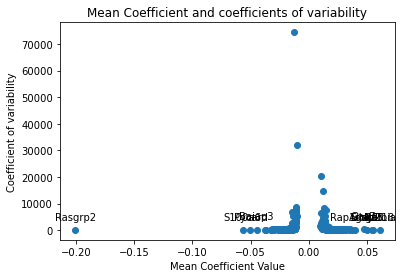

In [178]:
##### Plot mean coefficients against the coefficients of variability std()/var()

# dataframe of significant genes with mean and count
filtered = filtered

# plot points
# might have to catch NaN. That might not be plottable
plt.scatter(filtered['mean'], filtered['std']/filtered['var'])

# plot labels
plt.title('Mean Coefficient and coefficients of variability')
plt.xlabel('Mean Coefficient Value')
plt.ylabel('Coefficient of variability')

# zip joins x and y coordinates in pairs
l = filtered.reindex(filtered['mean'].abs().sort_values().index)[-10:].copy()


for x,y,g in zip(l['mean'], l['std']/l['var'], l.index):

    label = g

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

print('These are the 10 genes with highest coefficients: ')
print(l)
print()
print('These are the 10 least variable genes: ')
print((filtered['std']/filtered['var']).nsmallest(10))




These are the 10 genes with highest coefficients: 
          count      mean       var       std
Genes                                        
Rap1gap2     10  0.039506  0.000042  0.006490
Baiap3       10 -0.044864  0.000017  0.004143
Gas7         10  0.046891  0.000011  0.003276
Slc7a5       10  0.050124  0.000046  0.006790
Pycard       10 -0.050129  0.000029  0.005424
Arhgef18     10  0.053941  0.000025  0.004970
Atf3         10  0.055278  0.000031  0.005526
S100a6       10 -0.056884  0.000047  0.006874
Nfkbia       10  0.060753  0.000024  0.004904
Rasgrp2      10 -0.200456  0.000077  0.008799

These are the 10 most frequent genes: 
          count      mean       var       std
Genes                                        
Acaca        10 -0.022885  0.000011  0.003259
Agpat5       10  0.017045  0.000002  0.001412
Ak2          10 -0.016719  0.000003  0.001672
Amica1       10 -0.017492  0.000004  0.002016
Ankrd12      10 -0.029608  0.000007  0.002718
Arhgef18     10  0.053941  0.000025

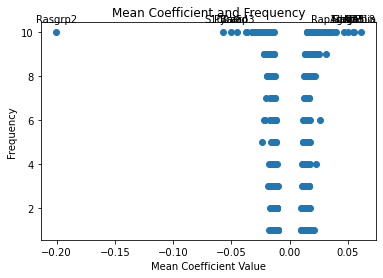

In [179]:
##### Plot mean coefficients against frequency 

# dataframe of significant genes with mean and count
filtered = filtered

# plot points
plt.scatter(filtered['mean'], filtered['count'])

# plot labels
plt.title('Mean Coefficient and Frequency')
plt.xlabel('Mean Coefficient Value')
plt.ylabel('Frequency')

# zip joins x and y coordinates in pairs
l = filtered.reindex(filtered['mean'].abs().sort_values().index)[-10:].copy()


for x,y,g in zip(l['mean'], l['count'], l.index):

    label = g

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

print('These are the 10 genes with highest coefficients: ')
print(l)
print()
print('These are the 10 most frequent genes: ')
print(filtered.nlargest(10, 'count'))



In [ ]:
##### Plot histogram of r2scores
plt.hist(metadata['r2scores'])

In [ ]:
  num_added += [len(sortedDF['Genes'][sortedDF.index[sortedDF['Probabilities']<0.05]].tolist())]

        for g in sortedDF['Genes'][sortedDF.index[sortedDF['Probabilities']<0.05]].tolist():    
            if g in top:
                top[g] += [myDF3.at[myDF3.index[myDF3['Genes']==g].item(), 'Coefficients']]
            else:
                top[g] = [myDF3.at[myDF3.index[myDF3['Genes']==g].item(), 'Coefficients']]
                
                
                return 
    names = np.array(list(top.items()))[:, 0]
    count = np.array([len(top[g]) for g in top.keys()])
    coef = np.array(list(top.values()))
    coefmean = np.array([sum(top[g]) / len(top[g]) for g in top.keys()])
    # create an anndata object? with r2 values, and somehow slice the different layers? dunno.

